In [1]:
import wfdb
import csv
import pandas as pd
import numpy as np
import os

In [2]:
import os
import csv
import pandas as pd
import wfdb  # Make sure wfdb is installed

output_dir = "data_creation"
os.makedirs(output_dir, exist_ok=True)

# Patient numbers
patient_numbers = [
    "100", "101", "102", "103", "104", "105", "106", "107", "108", "109",
    "111", "112", "113", "114", "115", "116", "117", "118", "119", "121",
    "122", "123", "124", "200", "201", "202", "203", "205", "207", "208",
    "209", "210", "212", "213", "214", "215", "217", "219", "220", "221",
    "222", "223", "228", "230", "231", "232", "233", "234"
]

# N = normal 
# S = supra-ventricular premature
# V = ventricular escape
# F = fusion of ventricular and normal
# Q = unclassified heartbeats
symbol_to_category = {
    'N': 'N', '.': 'N', 'L': 'N', 'R': 'N', 'e': 'N', 'j': 'N',
    'a': 'S', 'A': 'S', 'J': 'S', 'S': 'S',
    'V': 'V', 'E': 'V',
    'F': 'F',
    '/': 'Q', 'f': 'Q', 'Q': 'Q'
}

for patient_number in patient_numbers:
    try:
        # ECG data
        path_to_record = f"mit-database/{patient_number}"
        patient_record = wfdb.rdrecord(path_to_record)
        leads = patient_record.sig_name
        ecg_data = patient_record.p_signal

        # ECG CSV
        ecg_filename = f"{output_dir}/{patient_number}_ECG.csv"
        with open(ecg_filename, "w", newline='') as outfile:
            out_csv = csv.writer(outfile)
            out_csv.writerow(leads)
            for row in ecg_data:
                out_csv.writerow(row)

        # Annotations data
        annotation = wfdb.rdann(path_to_record, 'atr')
        symbols = annotation.symbol
        annotations = annotation.sample

        # Filter out symbols not in symbol_to_category
        filtered_symbols_annotations = [(sym, ann) for sym, ann in zip(symbols, annotations) if sym in symbol_to_category]
        categories = [symbol_to_category[sym] for sym, ann in filtered_symbols_annotations]
        annotations_filtered = [ann for sym, ann in filtered_symbols_annotations]

        df_annotations = pd.DataFrame({'Category': categories, 'Annotation': annotations_filtered})

        # Annotations CSV
        annotations_filename = f"{output_dir}/{patient_number}_Annotations.csv"
        df_annotations.to_csv(annotations_filename, index=False)

    except Exception as e:
        print(f"Failed to process: {patient_number}: {e}")

print("Done")

Done


In [3]:
import os
import pandas as pd
import numpy as np


def process_patient_data(patient_number, data_creation_dir="data_creation"):
    ecg_file_path = os.path.join(data_creation_dir, f"{patient_number}_ECG.csv")
    annotations_file_path = os.path.join(data_creation_dir, f"{patient_number}_Annotations.csv")
    
    patient_X = []
    patient_Y = []
    
    try:
        ecg_df = pd.read_csv(ecg_file_path)
        annotations_df = pd.read_csv(annotations_file_path)
    except FileNotFoundError:
        print(f"Files for patient {patient_number} not found. Skipping...")
        return [], []
    
    first_column_name = ecg_df.columns[0]
    second_column_name = ecg_df.columns[1] if len(ecg_df.columns) > 1 else None

    sampling_rate = 360  # Hz
    total_window_size_seconds = 2  # Total window size in seconds
    total_window_size_samples = total_window_size_seconds * sampling_rate

    for _, row in annotations_df.iterrows():
        annotation_point = row['Annotation']
        category = row['Category']
        
        # Randomly determine the window split around the annotation point
        before_seconds = np.random.uniform(0, total_window_size_seconds)
        after_seconds = total_window_size_seconds - before_seconds
        before_samples = int(before_seconds * sampling_rate)
        after_samples = int(after_seconds * sampling_rate)
        
        start_point = max(0, annotation_point - before_samples)
        end_point = start_point + total_window_size_samples  # Ensure the window is of the exact expected size
        
        # Adjust the end point if it exceeds the length of the data
        if end_point > len(ecg_df):
            end_point = len(ecg_df)
            start_point = max(0, end_point - total_window_size_samples)  # Adjust start point accordingly
        
        # Process data from the first column
        window_data_first_column = ecg_df.iloc[start_point:end_point][first_column_name].to_numpy()
        
        patient_X.append(window_data_first_column)
        patient_Y.append(category)
        
        # If there's a second column, process it and add as a new entry
        if second_column_name:
            window_data_second_column = ecg_df.iloc[start_point:end_point][second_column_name].to_numpy()
            
            patient_X.append(window_data_second_column)
            patient_Y.append(category)  # Repeat category for the new entry
    
    return patient_X, patient_Y



# Initialize lists to hold the entire dataset
all_X = []
all_Y = []

data_creation_dir = "data_creation"

# Process each patient
for patient_number in patient_numbers:
    patient_X, patient_Y = process_patient_data(patient_number, data_creation_dir)
    all_X.extend(patient_X)
    all_Y.extend(patient_Y)

X = np.array(all_X)
Y = np.array(all_Y)

In [4]:
X

array([[-0.145, -0.145, -0.145, ...,  0.   ,  0.   ,  0.   ],
       [-0.065, -0.065, -0.065, ...,  0.   ,  0.   ,  0.   ],
       [-0.145, -0.145, -0.145, ...,  0.   ,  0.   ,  0.   ],
       ...,
       [ 0.185,  0.185,  0.17 , ...,  0.   ,  0.   ,  0.   ],
       [-0.215, -0.22 , -0.225, ...,  0.   ,  0.   ,  0.   ],
       [ 0.12 ,  0.105,  0.105, ...,  0.   ,  0.   ,  0.   ]])

In [5]:
Y

array(['N', 'N', 'N', ..., 'N', 'N', 'N'], dtype='<U1')

In [6]:
df_x = pd.DataFrame(X)
df_x

,0,1,2,3,4,5,6,7,8,9,...,2150,2151,2152,2153,2154,2155,2156,2157,2158,2159
0,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.120,-0.135,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.065,-0.065,-0.065,-0.065,-0.065,-0.065,-0.065,-0.065,-0.080,-0.080,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.120,-0.135,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.065,-0.065,-0.065,-0.065,-0.065,-0.065,-0.065,-0.065,-0.080,-0.080,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.120,-0.135,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218983,0.165,0.155,0.135,0.155,0.160,0.155,0.155,0.160,0.165,0.180,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
218984,-0.290,-0.290,-0.280,-0.295,-0.300,-0.295,-0.285,-0.265,-0.245,-0.250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
218985,0.185,0.185,0.170,0.160,0.145,0.140,0.135,0.150,0.175,0.180,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
218986,-0.215,-0.220,-0.225,-0.225,-0.230,-0.230,-0.245,-0.250,-0.250,-0.235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_x = scaler.fit_transform(df_x)
df_x = pd.DataFrame(df_x)


In [8]:
import pywt

def madev(d, axis=None):
    'Mean absolute deviation of a signal'
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def wavelet_denoising(x, wavelet='sym4', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    return pywt.waverec(coeff, wavelet, mode='per')


df_x = wavelet_denoising(df_x, wavelet='sym4', level=2)
df_x = pd.DataFrame(df_x)


In [9]:
df_y = pd.DataFrame(Y, columns=['ColumnName'])
print(df_y)

       ColumnName
0               N
1               N
2               N
3               N
4               N
...           ...
218983          N
218984          N
218985          N
218986          N
218987          N

[218988 rows x 1 columns]


In [10]:
value_counts_y = df_y['ColumnName'].value_counts()
print(value_counts_y)

ColumnName
N    181262
Q     16086
V     14472
S      5562
F      1606
Name: count, dtype: int64


In [11]:
df_fusionné = pd.concat([df_y, df_x], axis=1)
df_fusionné

,ColumnName,0,1,2,3,4,5,6,7,8,...,2150,2151,2152,2153,2154,2155,2156,2157,2158,2159
0,N,0.492112,0.491537,0.490969,0.490418,0.489880,0.489346,0.488833,0.488321,0.487748,...,0.498712,0.498091,0.497478,0.496852,0.496225,0.495586,0.494891,0.494181,0.493452,0.492731
1,N,0.497856,0.497648,0.497394,0.497105,0.496840,0.496567,0.496277,0.495971,0.495616,...,0.497662,0.497651,0.497684,0.497736,0.497768,0.497798,0.497856,0.497903,0.497962,0.497989
2,N,0.492115,0.491540,0.490972,0.490420,0.489881,0.489347,0.488834,0.488320,0.487747,...,0.498719,0.498098,0.497484,0.496858,0.496231,0.495591,0.494895,0.494186,0.493457,0.492735
3,N,0.497864,0.497655,0.497401,0.497111,0.496846,0.496573,0.496282,0.495976,0.495620,...,0.497673,0.497662,0.497694,0.497746,0.497778,0.497807,0.497865,0.497912,0.497970,0.497997
4,N,0.492205,0.491626,0.491054,0.490498,0.489955,0.489417,0.488900,0.488382,0.487805,...,0.498833,0.498209,0.497593,0.496964,0.496335,0.495693,0.494995,0.494284,0.493552,0.492828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218983,N,0.509881,0.510380,0.510838,0.511241,0.511619,0.511977,0.512282,0.512572,0.512948,...,0.501625,0.502400,0.503197,0.504019,0.504820,0.505629,0.506529,0.507433,0.508365,0.509256
218984,N,0.483454,0.479103,0.473452,0.468256,0.469077,0.471966,0.476174,0.480672,0.480864,...,0.503148,0.503890,0.502530,0.500303,0.497400,0.494220,0.492045,0.489960,0.488721,0.487414
218985,N,0.510210,0.510687,0.511101,0.511453,0.511816,0.512161,0.512461,0.512737,0.513017,...,0.501693,0.502473,0.503296,0.504154,0.504987,0.505829,0.506766,0.507701,0.508670,0.509591
218986,N,0.487116,0.485461,0.484125,0.482907,0.481188,0.479520,0.477776,0.476302,0.476371,...,0.502863,0.503480,0.502588,0.501017,0.499200,0.497126,0.495155,0.493189,0.491037,0.488904


In [12]:
line = df_fusionné.loc[df_fusionné['ColumnName'] == 'F']
line

,ColumnName,0,1,2,3,4,5,6,7,8,...,2150,2151,2152,2153,2154,2155,2156,2157,2158,2159
35688,F,0.467736,0.467289,0.466809,0.466295,0.465778,0.465251,0.464700,0.464143,0.463613,...,0.469748,0.469531,0.469366,0.469218,0.469042,0.468856,0.468688,0.468502,0.468321,0.468106
35689,F,0.510091,0.510934,0.511856,0.512771,0.513415,0.513992,0.514579,0.515135,0.516112,...,0.502002,0.502828,0.503588,0.504340,0.505102,0.505875,0.506701,0.507551,0.508389,0.509233
36800,F,0.473461,0.474335,0.475142,0.475862,0.476542,0.477190,0.477752,0.478291,0.478965,...,0.459497,0.460821,0.462186,0.463592,0.464959,0.466335,0.467846,0.469356,0.470906,0.472390
36801,F,0.470799,0.471729,0.463667,0.474000,0.470487,0.466448,0.470127,0.475755,0.475036,...,0.566639,0.559989,0.561744,0.566254,0.565523,0.562374,0.565697,0.563530,0.558538,0.565752
38328,F,0.451394,0.450960,0.450597,0.450373,0.450204,0.450061,0.450068,0.450081,0.449700,...,0.461277,0.462490,0.462188,0.461199,0.460079,0.458714,0.457210,0.455683,0.453916,0.452213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210255,F,0.508493,0.510733,0.512855,0.515189,0.518222,0.521290,0.524561,0.527538,0.528291,...,0.506730,0.507460,0.507717,0.507753,0.508016,0.508260,0.507984,0.507715,0.507265,0.507037
210556,F,0.571401,0.574172,0.580972,0.569391,0.572989,0.577514,0.574231,0.568914,0.569227,...,0.477123,0.478703,0.477014,0.474380,0.478511,0.485539,0.481750,0.481914,0.486495,0.480026
210557,F,0.529609,0.509673,0.504905,0.504848,0.502921,0.501444,0.503431,0.506298,0.505230,...,0.541053,0.543287,0.543187,0.542170,0.539106,0.535719,0.535159,0.534185,0.538804,0.544262
212980,F,0.474612,0.484549,0.474955,0.470769,0.470543,0.474345,0.479862,0.488106,0.502122,...,0.643829,0.655105,0.654978,0.647495,0.640438,0.629325,0.603902,0.572474,0.539668,0.513613


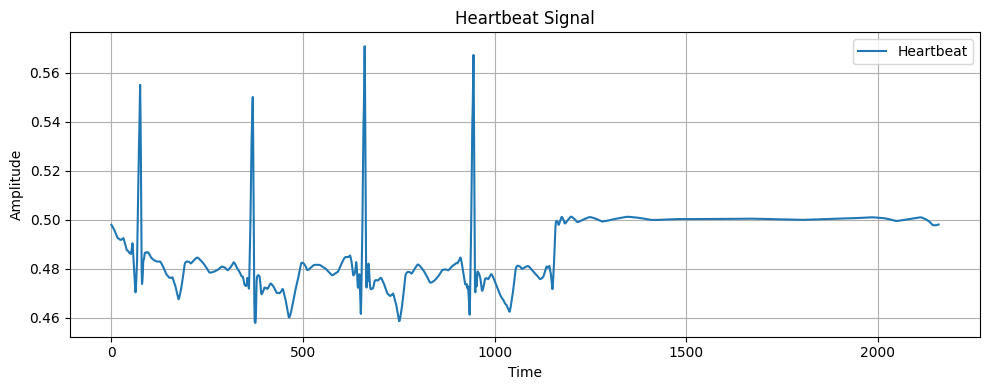

In [13]:
import matplotlib.pyplot as plt
import numpy as np

heartbeat_values = df_fusionné.iloc[1,1:]

time_axis = np.arange(0, 2160)

# Plotting the heartbeat
plt.figure(figsize=(10, 4))
plt.plot(time_axis, heartbeat_values, label='Heartbeat')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Heartbeat Signal')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

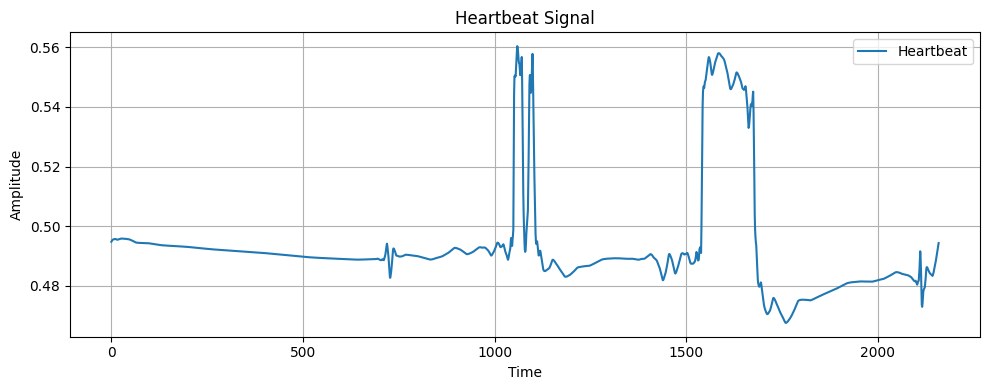

In [14]:
import matplotlib.pyplot as plt
import numpy as np

heartbeat_values = df_fusionné.iloc[5267,1:]
heartbeat_values
# Creating a time axis for the 3600 points, assuming each point represents a unit of time
time_axis = np.arange(0, 2160)

# Plotting the heartbeat
plt.figure(figsize=(10, 4))
plt.plot(time_axis, heartbeat_values, label='Heartbeat')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Heartbeat Signal')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()